In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
#import mpld3
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import scipy.stats as stats

%matplotlib inline

In [2]:
example_datafile = 'example_data.txt'
filter_config = '../cpp/tests/assembly/connectivity.txt'
output_data = '../cpp/test_output.txt'

fed = open(example_datafile, 'r')
fc = open(filter_config, 'r')

In [3]:
fed = open(example_datafile, 'r')

begin_data = False
dns_data = {}
for line in fed.readlines():
    
    if begin_data:
        
        if "t = " in line:
            tc = float(line[3:])
            dns_data.update({tc:np.empty((0, 3))})
        else:
            data = [s.replace(',', '') for s in line.split()]
            pos = np.array([float(data[i]) for i in range(2, 5)])
            dns_data[tc] = np.vstack([dns_data[tc], pos])
    
    if (line.strip() == "BEGIN DATA"):
        begin_data = True
    
fed.close()

In [4]:
fc = open(filter_config, 'r')

begin_data = False

nodes = {}
conn = {}

for line in fc.readlines():
    
    if begin_data:
    
        data = [s.replace(',', '') for s in line.split()]
        
        if(len(data)>0):
        
            if (data[0]=='N'):
                nid = int(data[1])
                pos = np.array([float(data[i]) for i in range(2, len(data))])
                nodes.update({nid:pos})
                
            elif (data[0]=='E'):
                eid = int(data[2])
                nids = [int(data[i]) for i in range(3, len(data))]
                conn.update({eid:nids})
        
    if (line.strip() == "BEGIN DATA"):
        begin_data = True

print(nodes)
print(conn)
fc.close()

{1: array([0., 0., 0.]), 2: array([1., 0., 0.]), 3: array([1., 1., 0.]), 4: array([0., 1., 0.]), 5: array([0., 0., 1.]), 8: array([1., 0., 1.]), 6: array([1., 1., 1.]), 7: array([0., 1., 1.])}
{10: [1, 2, 3, 4, 5, 8, 6, 7]}


In [39]:
def read_values(file):
    
    last_pos = file.tell()
    line = file.readline().strip()
    while (len(line)==0):
        line = file.readline()
            
    sline = [v.strip() for v in line.split(',') if len(v.strip())>0]
    kwdata = np.array([float(s) for s in sline])
        
    last_pos = file.tell()
    line = file.readline()
    while not ("*" in line):
        if (len(line)==0):
            last_pos = file.tell()
            line = file.readline().strip()
            continue
        sline = [v.strip() for v in line.split(',') if len(v.strip())>0]
        kwdata = np.vstack([kwdata, [float(s) for s in sline]])
        x = file.tell()
        line = file.readline().strip()
    file.seek(x)
    return kwdata


In [41]:
of = open(output_data, 'r')

filter_results = {}

fnum = -1

class MicromorphicFilterData(object):
    def __init__(self):
        nodes = []
        dof_values = []

nodes = []
dof_values = []
        
line = of.readline()
    
while line != '':
    
    if (len(line)==0):
        continue
    
    line = line.strip()
    sline = line.split(',')
    
    if "*INPUT_FILE" in sline[0]:
        print("Reading data from: ", sline[1])
    
    elif "*FILTER_CONFIGURATION" in sline[0]:
        print("Filter defined in: ", sline[1])
    
    elif "*ELEMENT" in sline[0]:
        do_nothing=0
        
    elif "*NODES" in sline[0]:
        nodes = read_values(of)
        print(nodes)
    
    elif "*TIMESTEP" in sline[0]:
        
        sline = line.split(',')
        time = float(sline[1])
        filter_results.update({time:{}})
            
    elif "*MICROMORPHIC FILTER" in line:
        if fnum != -1:
            filter_results[time].update({fnum:mfdata})
        fnum = int(sline[1])
        mfdata = MicromorphicFilterData()
        
    elif "*DOF VALUES" in line:
        dof_values = read_values(of)
        
    else:
        print(sline)
        data_array.append([float(v) for v in sline])
        
        
    line = of.readline()
    print(line)
filter_results

Reading data from:   ../python/example_data.txt
*FILTER_CONFIGURATION_FILE, ./tests/assembly/connectivity.txt

Filter defined in:   ./tests/assembly/connectivity.txt
*TIMESTEP, 0

*MICROMORPHIC FILTER, 10

 *ELEMENT

  *NODES

[[0. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 1. 1.]
 [0. 1. 1.]]
 *DOF VALUES

 *GAUSS POINT INFORMATION

['*GAUSS POINT INFORMATION']


NameError: name 'data_array' is not defined

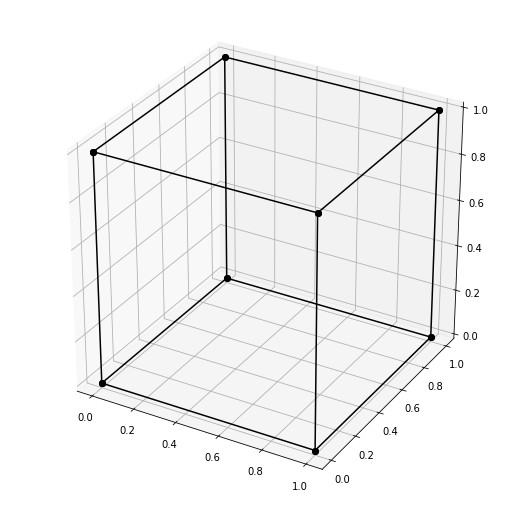

In [5]:
#Assume hex8 for now
def plot_hex(eid, nodes, conn, u, ax):
    #Plot bottom square
    x = np.array([nodes[n]+u[n] for n in conn[eid][:4]] + [nodes[conn[eid][0]]+u[conn[eid][0]]])
    #print(x)
    ax.plot(*zip(*x), color='k', marker='o')
    #Plot top square
    x = np.array([nodes[n]+u[n] for n in conn[eid][4:]] + [nodes[conn[eid][4]]+u[conn[eid][4]]])
    #print(x)
    ax.plot(*zip(*x), color='k', marker='o')
    #Plot sides
    for i in range(4):
        x = [nodes[conn[eid][i]]+u[conn[eid][i]], nodes[conn[eid][i+4]]+u[conn[eid][i+4]]]
        #print(x)
        ax.plot(*zip(*x), color='k', marker='o')

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
u = dict((key, np.zeros(3)) for key in nodes.keys())
plot_hex(10, nodes, conn, u, ax)
plt.show()

{1: array([ 0.320405 , -0.0491271,  0.198477 ]), 2: array([0.411785 , 0.0884694, 0.266938 ]), 3: array([0.322491 , 0.0348602, 0.400699 ]), 4: array([ 0.231111, -0.102736,  0.332238]), 5: array([ 0.271983, -0.232928,  0.170432]), 8: array([ 0.363363 , -0.0953316,  0.238893 ]), 6: array([ 0.274069, -0.148941,  0.372654]), 7: array([ 0.182689, -0.286537,  0.304193])}
0.1


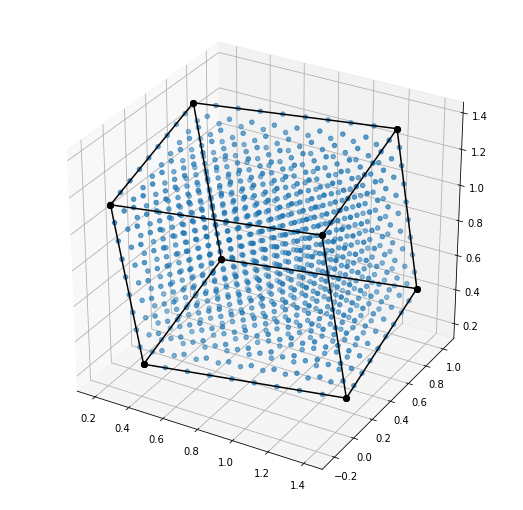

In [6]:
us = np.array([[0.320405, -0.0491271, 0.198477],
[0.411785, 0.0884694, 0.266938],
[0.322491, 0.0348602, 0.400699],
[0.231111, -0.102736, 0.332238],
[0.271983, -0.232928, 0.170432],
[0.274069, -0.148941, 0.372654],
[0.182689, -0.286537, 0.304193],
[0.363363, -0.0953316, 0.238893],
])

u = dict([(key, us[key-1]) for key in nodes.keys()])
print(u)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
for i, key in enumerate(dns_data.keys()):
    if (i != 1):
        continue
    else:
        print(key)
    data = dns_data[key]
    ax.scatter(*zip(*data), label='t = {0:1.4f}'.format(key))
plot_hex(10, nodes, conn, u, ax)
plt.show()

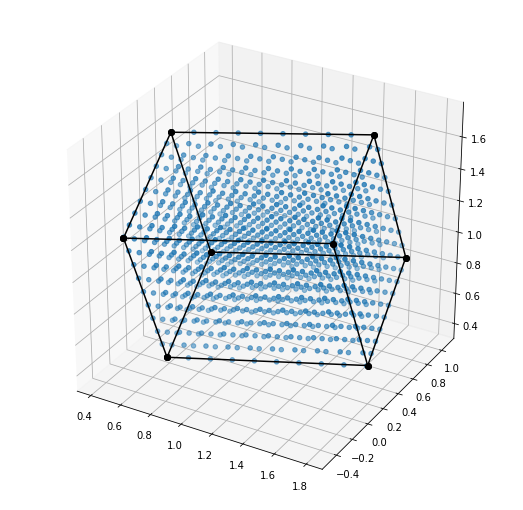

In [7]:
us = np.array([[0.640639, -0.098202, 0.397208],
[0.79903, 0.194605, 0.553163],
[0.62004, 0.0620635, 0.806926],
[0.46165, -0.230744, 0.650971],
[0.588142, -0.464059, 0.306796],
[0.567544, -0.303793, 0.716514],
[0.409153, -0.596601, 0.560559],
[0.746533, -0.171251, 0.462751],
])



u = dict([(key, us[key-1]) for key in nodes.keys()])

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
for i, key in enumerate(dns_data.keys()):
    if (i != 2):
        continue
    data = dns_data[key]
    ax.scatter(*zip(*data), label='t = {0:1.4f}'.format(key))
plot_hex(10, nodes, conn, u, ax)

1 [ 1.60001  -0.246049  0.994842]
2 [2.78024  0.549511 1.51795 ]
3 [2.40538   1.0632156 2.02854  ]
4 [1.22516  0.267656 1.50542 ]
5 [ 1.79318  -1.00711   1.550976]
8 [ 2.97341  -0.211546  2.07409 ]
6 [2.59855  0.302159 2.58467 ]
7 [ 1.41833 -0.4934   2.06156]


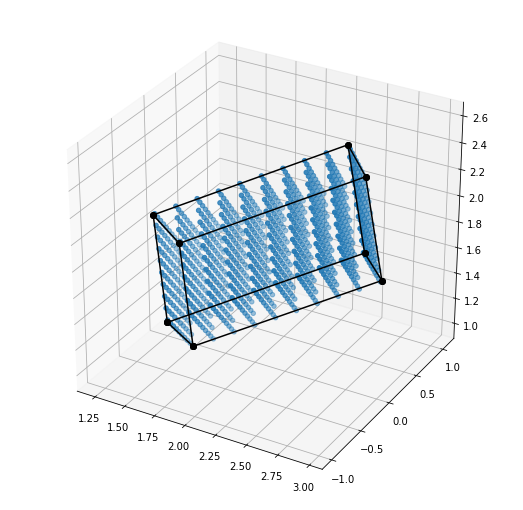

In [8]:
us = np.array([[1.60001, -0.246049, 0.994842],
[1.78024, 0.549511, 1.51795],
[1.40538, 0.0632156, 2.02854],
[1.22516, -0.732344, 1.50542],
[1.79318, -1.00711, 0.550976],
[1.59855, -0.697841, 1.58467],
[1.41833, -1.4934, 1.06156],
[1.97341, -0.211546, 1.07409],
])


u = dict([(key, us[key-1]) for key in nodes.keys()])

for n in conn[10]:
    print(n, nodes[n] + u[n])

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
for i, key in enumerate(dns_data.keys()):
    if (i != 5):
        continue
    data = dns_data[key]
    ax.scatter(*zip(*data), label='t = {0:1.4f}'.format(key))
plot_hex(10, nodes, conn, u, ax)